In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import requests as r
import pandas as pd
import numpy as np

# 1. Introdução

Neste notebook, realizo uma Análise Exploratória de Dados (EDA) em um conjunto de dados de filmes. O objetivo principal é entender a distribuição e as características das variáveis, além de identificar relações e gerar hipóteses que possam guiar as análises futuras. Por fim, estas descobertas servirão de base para a construção de um modelo preditivo.

# 2. Carregamento e análise inicial dos Dados

Para começar, vamos carregar os dados e realizar uma primeira inspeção para entender a estrutura do dataset, o número de linhas e o tipo de dados de cada coluna.

In [2]:
df_raw = pd.read_csv('input/desafio_indicium_imdb.csv', index_col='Unnamed: 0')
df = df_raw.copy()
df.head(5)

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


## 2.1 Análise Inicial

In [3]:
df.isna().sum()

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [4]:
df.dtypes

Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

In [5]:
df.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,842.000000,9.990000e+02
mean,7.947948,77.969121,2.716214e+05
std,0.272290,12.383257,3.209126e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.547150e+04
50%,7.900000,79.000000,1.383560e+05
75%,8.100000,87.000000,3.731675e+05
max,9.200000,100.000000,2.303232e+06


- Foram identificados valores ausentes em três colunas: **Certificate**, **Meta_score** e **Gross**.
- As colunas **Released_Year**, **Runtime** e **Gross** estão classificadas como tipo object, apesar de conterem dados numéricos. A conversão para o tipo int é necessária para permitir operações matemáticas.
- A estatística descritiva indica que o conjunto de dados é formado por filmes de alta qualidade. A média de IMDB_Rating é 7.95, com um desvio padrão de 0.27, e a média de Meta_score é 77.97, com um desvio padrão de 12.38.

# 3. Limpeza e Pré-processamento dos Dados

## 3.1 Tratamento de Dados Ausentes

Vamos iniciar a fase de limpeza tratando os valores ausentes (NaNs) identificados nas colunas 'Certificate', 'Meta_score' e 'Gross'. A estratégia adotada será de preencher os valores ausentes de forma que a integridade dos dados seja mantida.

### 3.1.1 Tratamento da Coluna 'Certificate'

A coluna 'Certificate' foi identificada com valores nulos e classificações não padronizadas. Para limpar e preparar os dados, as categorias serão unificadas (ex: 'UA' e 'U/A' em 'PG-13') e os valores ausentes serão preenchidos com 'Not Rated'. Em seguida, por ser uma variável categórica nominal, ela será convertida em um formato numérico através da técnica de one-hot encoding, criando colunas binárias para cada classificação e tornando-a adequada para a modelagem preditiva.

In [6]:
df_raw['Certificate'].value_counts(dropna=False)

Certificate
U           234
A           196
UA          175
R           146
NaN         101
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: count, dtype: int64

In [7]:
certificate_mapping = {
    'GP': 'PG',
    'Unrated': 'Not Rated',
    'U': 'G',
    'A': 'NC-17',
    '16': 'R',
    'UA': 'PG-13',
    'U/A': 'PG-13',
    'TV-PG': 'TV-Rated',
    'TV-14': 'TV-Rated',
    'TV-MA': 'TV-Rated',
    'Passed': 'Old-Rated',
    'Approved': 'Old-Rated'
}

df['Certificate'] = df['Certificate'].replace(certificate_mapping)

df['Certificate'] = df['Certificate'].fillna('Not Rated')

df['Certificate'].value_counts()

Certificate
G            246
PG-13        219
NC-17        196
R            147
Not Rated    102
Old-Rated     45
PG            39
TV-Rated       5
Name: count, dtype: int64

In [8]:
df_certificate_encoded = pd.get_dummies(df['Certificate'], prefix='Certificate', dtype=int)

df = pd.concat([df, df_certificate_encoded], axis=1)

### 3.1.2 Tratamento e transformação das Colunas 'Meta_score', 'Gross' e 'Meta_score'

A coluna Gross indica o faturamento, a coluna está com o tipo de dado object, e com vírgulas, será feita a remoção das vírgulas e correção do tipo de dado.

Optei pela remoção das linhas com faturamento 'Gross' e 'Meta_score' ausentes para garantir que o modelo fosse treinado apenas com dados completos e observados, evitando a introdução de possíveis vieses que técnicas de imputação poderiam gerar, especialmente em variáveis-chave como o faturamento. Adicionalmente, para lidar com as distribuições assimétricas das colunas Gross e No_of_Votes, foram criadas versões transformadas em log (Gross_log e No_of_Votes_log). Essas transformações garantem que o conjunto de dados esteja limpo, íntegro e mais adequado para a visualização das relações entre as variáveis e para a construção de um modelo preditivo.

In [9]:
df.dropna(inplace=True)

In [10]:
df['Gross'] = pd.to_numeric(df['Gross'].str.replace(',', '', regex=False))

df['Gross_log'] = np.log1p(df['Gross'])

df['No_of_Votes_log'] = np.log1p(df['No_of_Votes'])

## 3.2 Análise e Tratamento por Variável

### 3.2.1 Coluna 'Released_Year'

A coluna Released_Year, apesar de conter principalmente valores numéricos, foi identificada como tipo de dado object. Uma inspeção mais detalhada revelou a presença de um valor incorreto, 'PG', na linha referente ao filme 'Apollo 13'. Para corrigir este erro de entrada de dados, o ano correto do filme (1995) foi obtido através de uma consulta à API do OMDb, garantindo a integridade dos dados para análises futuras. A coluna será convertida para um tipo numérico na sequência.

In [11]:
df['Released_Year'].unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2019',
       '2014', '1998', '1997', '1995', '1991', '1977', '1954', '2011',
       '2006', '2000', '1988', '1985', '1968', '1960', '1942', '1936',
       '1931', '2018', '2016', '2017', '2012', '2009', '1981', '1979',
       '1964', '2004', '1992', '1987', '1986', '1984', '1983', '1976',
       '1973', '1971', '1965', '1962', '1959', '1958', '1952', '1944',
       '1941', '1927', '2013', '2007', '2005', '1989', '1963', '1955',
       '1950', '1948', '2015', '1996', '1982', '1978', '1967', '1951',
       '1949', '1940', '1939', '1934', '1970', '1969', '1961', '1946',
       '1930', '1925', '1947', '1938', '1933', '1935', 'PG', '1953'],
      dtype=object)

In [12]:
title = df[df['Released_Year'] == 'PG']['Series_Title'].iloc[0]

OMDB_API_KEY = "93368b69"

url = f"http://www.omdbapi.com/?t={title}&apikey={OMDB_API_KEY}"

response = r.get(url)

df.loc[df['Series_Title'] == title, "Released_Year"] = response.json()['Year']

In [13]:
df['Released_Year'] = df['Released_Year'].astype(int)

### 3.2.2 Coluna 'Runtime'

A coluna 'Runtime' indica a duração do filme em minutos. Por conter a string 'min' junto ao valor numérico, a coluna está com o tipo de dado object e precisa ser convertida para um tipo numérico para análises quantitativas.

In [14]:
df['Runtime'].unique()

array(['175 min', '152 min', '202 min', '96 min', '201 min', '154 min',
       '195 min', '148 min', '139 min', '178 min', '142 min', '161 min',
       '179 min', '136 min', '146 min', '124 min', '133 min', '132 min',
       '169 min', '130 min', '125 min', '189 min', '116 min', '127 min',
       '118 min', '121 min', '207 min', '122 min', '106 min', '112 min',
       '151 min', '150 min', '155 min', '119 min', '110 min', '88 min',
       '137 min', '165 min', '109 min', '102 min', '87 min', '126 min',
       '117 min', '181 min', '149 min', '105 min', '164 min', '170 min',
       '98 min', '101 min', '113 min', '134 min', '115 min', '147 min',
       '95 min', '123 min', '131 min', '153 min', '108 min', '104 min',
       '89 min', '81 min', '99 min', '160 min', '114 min', '129 min',
       '228 min', '128 min', '103 min', '107 min', '140 min', '138 min',
       '180 min', '158 min', '156 min', '135 min', '86 min', '162 min',
       '91 min', '172 min', '145 min', '196 min', '93 min', 

In [15]:
df['Runtime'] = df['Runtime'].str.replace(' min', '').astype(int)

In [16]:
df['Runtime'].dtype

dtype('int32')

### 3.2.3 Criação de novas colunas 'Movie_Age', 'Star_Frequency' e 'Director_Frequency'

- Idade do Filme: Será adicionada uma nova coluna que calcula a idade de cada filme em relação ao ano atual, usando a coluna **Released_Year**.
- Frequência de Estrelas (Atores/Atrizes): A coluna será criada para medir a frequência de aparição de cada ator e atriz no dataset. O valor da coluna para cada filme será a soma das frequências de todos os seus atores.
- Frequência de Diretores: Representa a frequência de aparição de cada diretor no dataset, servindo como uma medida da prolificidade do diretor e do seu impacto potencial na nota de um filme.

In [17]:
current_year = datetime.now().year
df['Movie_Age'] = current_year - df['Released_Year']

df[['Series_Title', 'Released_Year', 'Movie_Age']].head()

,Series_Title,Released_Year,Movie_Age
1,The Godfather,1972,53
2,The Dark Knight,2008,17
3,The Godfather: Part II,1974,51
4,12 Angry Men,1957,68
5,The Lord of the Rings: The Return of the King,2003,22


In [18]:
star_columns = ['Star1', 'Star2', 'Star3', 'Star4']

all_actors = df[star_columns].stack().dropna()
actor_frequencies = all_actors.value_counts()

def calculate_star_frequency(row):
    total_frequency = 0
    
    for col in star_columns:
        actor = row[col]
        total_frequency += actor_frequencies.get(actor, 0)

    return total_frequency

df['Star_Frequency'] = df.apply(calculate_star_frequency, axis=1)

df[['Series_Title', 'Star1', 'Star2', 'Star3', 'Star4', 'Star_Frequency']].head()

,Series_Title,Star1,Star2,Star3,Star4,Star_Frequency
1,The Godfather,Marlon Brando,Al Pacino,James Caan,Diane Keaton,25
2,The Dark Knight,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,21
3,The Godfather: Part II,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,37
4,12 Angry Men,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,11
5,The Lord of the Rings: The Return of the King,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,19


In [19]:
director_frequencies = df['Director'].value_counts()
df['Director_Frequency'] = df['Director'].map(director_frequencies)

top_n_directors = 20
top_directors = director_frequencies.nlargest(top_n_directors).index

for director in top_directors:
    df[f'Director_{director.replace(" ", "_")}'] = (df['Director'] == director).astype(int)

### 3.2.4 Coluna 'Genre'

A coluna Genre contém múltiplos gêneros por filme, o que impede a análise direta e a utilização em modelos preditivos. Para a fase de Análise Exploratória de Dados (EDA), um DataFrame auxiliar (df_genres) será criado, onde cada gênero terá sua própria linha, facilitando a visualização da distribuição das notas. Para a fase de modelagem, será aplicada a técnica de one-hot encoding diretamente no DataFrame principal, transformando cada gênero em uma coluna binária e mantendo o formato de uma linha por filme.

In [20]:
df_genres = df.copy()

df_genres['Genre'] = df_genres['Genre'].str.split(', ')

df_genres = df_genres.explode('Genre')

df_genres.Genre.value_counts()

Genre
Drama        530
Comedy       166
Adventure    165
Crime        151
Action       143
Thriller     104
Romance       91
Biography     88
Mystery       73
Animation     64
Sci-Fi        58
Fantasy       55
Family        45
History       39
War           33
Music         28
Horror        21
Sport         17
Western       16
Musical       11
Film-Noir      8
Name: count, dtype: int64

In [21]:
df_encoded = df.copy()

df_encoded['Genre'] = df_encoded['Genre'].str.split(', ')

df_exploded = df_encoded.explode('Genre')

df_one_hot = pd.get_dummies(df_exploded, columns=['Genre'], prefix='Genre')

df_genres_encoded = df_one_hot.groupby('Series_Title').sum()

df = df.merge(df_genres_encoded, on='Series_Title')

df = df.drop(columns=df.filter(like='_y').columns)

df.columns = df.columns.str.replace('_x$', '', regex=True)

### 3.2.5 Colunas 'Star'

A criação de uma coluna para cada ator no dataset resultaria em uma alta dimensionalidade, o que pode prejudicar o desempenho do modelo preditivo. Para evitar esse problema e, ao mesmo tempo, capturar a influência dos atores de maior impacto, será utilizada a estratégia de one-hot encoding seletivo.

Com essa abordagem, novas colunas binárias serão criadas apenas para os 20 atores mais frequentes, permitindo que o modelo identifique a correlação entre a presença desses atores e a nota do filme no IMDb.

In [22]:
top_n_stars = 20
top_stars = actor_frequencies.nlargest(top_n_stars).index

for star in top_stars:
    df[f'Star_{star.replace(" ", "_")}'] = df[star_columns].apply(lambda x: 1 if star in x.values else 0, axis=1)

### 3.2.5 Coluna 'Overview'

A coluna Overview, que contém a sinopse de cada filme, é uma fonte de dados rica e não estruturada. Para utilizar essa informação em nossos modelos de machine learning, que só operam com dados numéricos, foi necessário aplicar técnicas de NLP para transformar o texto em features.

In [23]:
df_tmp = df.copy()

df_tmp['Overview'] = df_tmp['Overview'].str.lower()

vectorizer = CountVectorizer(stop_words='english', max_features=100, ngram_range=(1, 3))

overview_bow = vectorizer.fit_transform(df_tmp['Overview'])

overview_df = pd.DataFrame(overview_bow.toarray(), columns=vectorizer.get_feature_names_out())

df = pd.concat([df_tmp, overview_df], axis=1)

# 4. Análise Exploratória de Dados (EDA)

## Matriz de Correlação

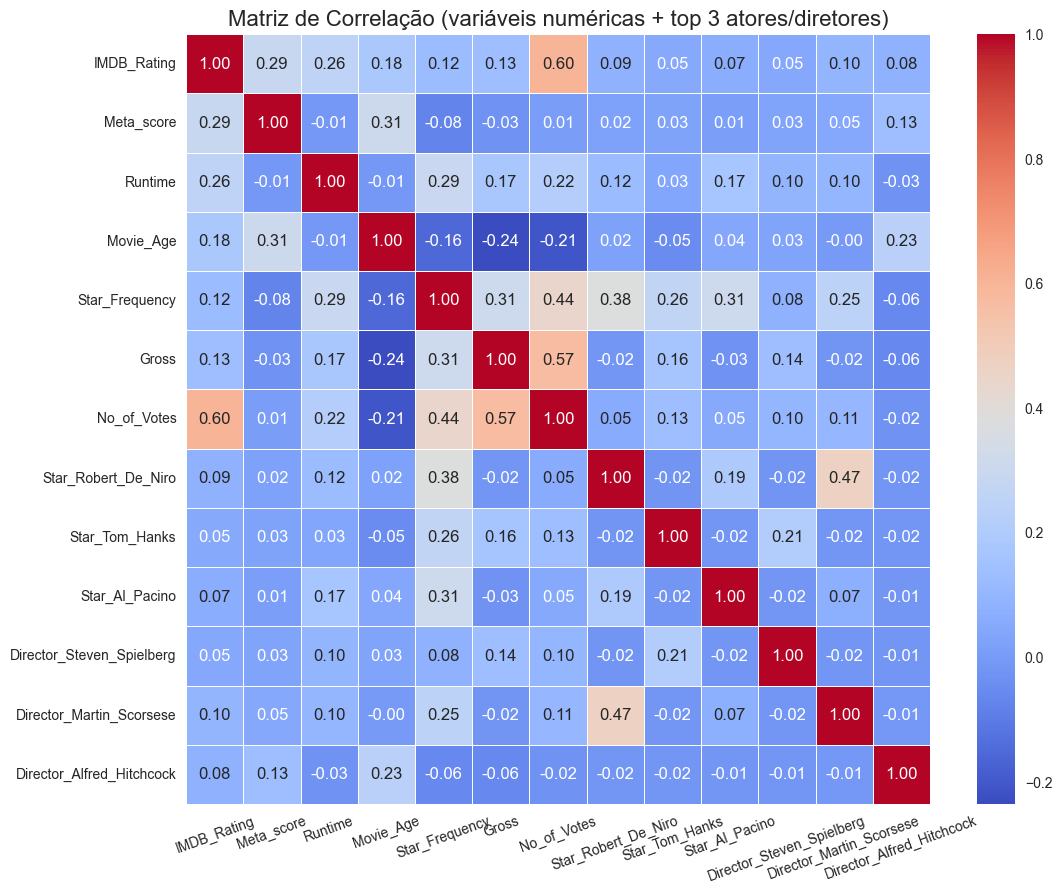

In [24]:
top3_star = ['Star_'+_.replace(' ', '_')for _ in actor_frequencies.iloc[:3].index.tolist()]
top3_director = ['Director_'+_.replace(' ', '_')for _ in director_frequencies.iloc[:3].index.tolist()]

num_cols = ['IMDB_Rating', 'Meta_score', 'Runtime', 'Movie_Age', 'Star_Frequency', 'Gross', 'No_of_Votes'] + top3_star + top3_director

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação (variáveis numéricas + top 3 atores/diretores)', fontsize=16)
plt.xticks(rotation=20)
plt.show()

## 4.1 Relação entre a Nota do Público e da Crítica

### Hipótese:
Existe uma forte correlação positiva entre a nota do público (IMDB_Rating) e a nota da crítica (Meta_score).

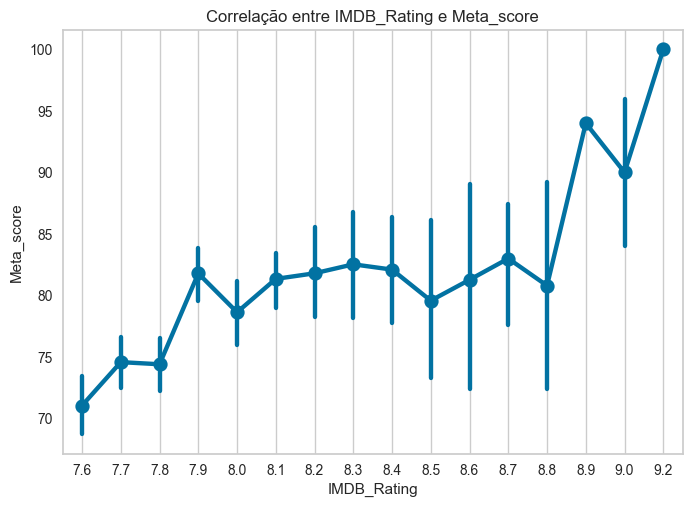

In [25]:
sns.pointplot(df, x='IMDB_Rating', y='Meta_score')
plt.title('Correlação entre IMDB_Rating e Meta_score')
plt.grid()
plt.show()

#### Insight:
Apesar de uma tendência positiva no pointplot, a correlação de apenas 0.29 indica uma relação fraca entre a nota do público (IMDB_Rating) e a nota da crítica (Meta_score). Isso sugere que, embora ligeiramente alinhadas, as opiniões de críticos e espectadores frequentemente divergem.

## 4.2 Relação entre Popularidade e Faturamento

### Hipótese:
A bilheteria (Gross) de um filme está diretamente relacionada com sua popularidade, que pode ser medida pelo número de votos (No_of_Votes). Filmes com mais votos tendem a ter maior faturamento.

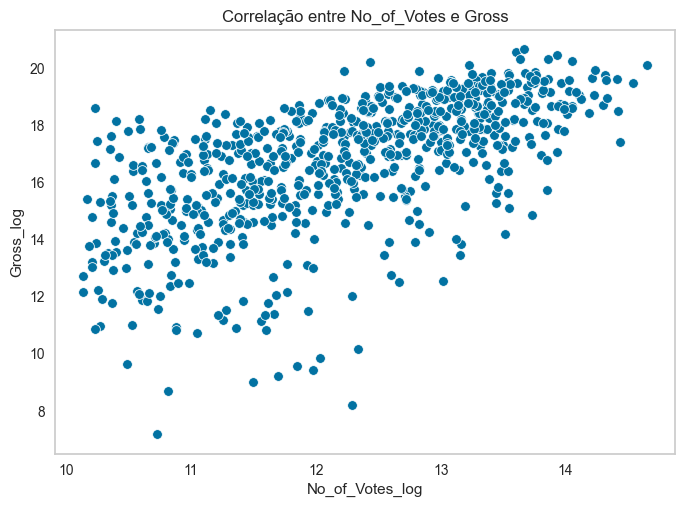

In [26]:
sns.scatterplot(df, x='No_of_Votes_log', y='Gross_log')
plt.title('Correlação entre No_of_Votes e Gross')
plt.grid()
plt.show()

#### Insight:
O gráfico de dispersão mostra uma clara tendência positiva: conforme o número de votos de um filme aumenta (No_of_Votes_log), seu faturamento (Gross_log) também tende a aumentar. A correlação de 0.62 encontrada na matriz reforça essa visualização, confirmando que a popularidade de um filme é um fator relevante para o seu sucesso financeiro.

## 4.3 Variação de Nota por Gênero

### Hipótese:
A nota média (IMDB_Rating) de um filme varia significativamente entre os diferentes gêneros. Alguns gêneros são consistentemente mais bem avaliados pelo público do que outros.

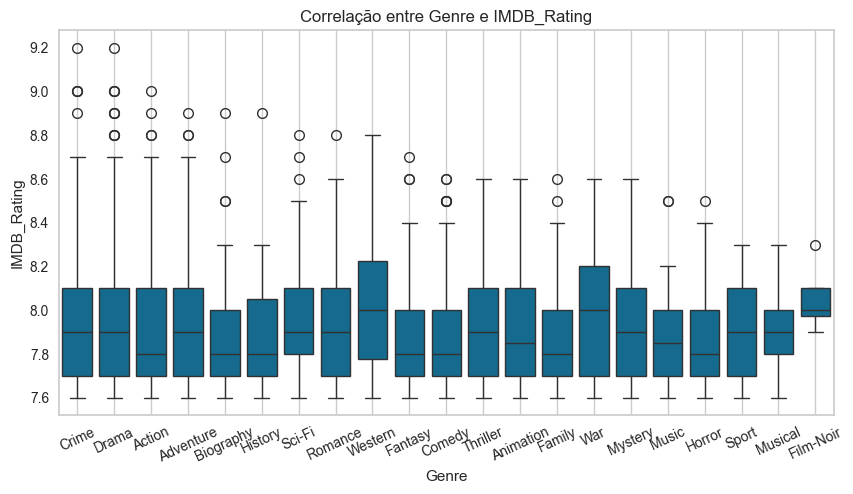

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(df_genres, x='Genre', y='IMDB_Rating')
plt.title('Correlação entre Genre e IMDB_Rating')
plt.xticks(rotation=25)
plt.grid()
plt.show()

#### Insight:
A análise do boxplot sugere que a hipótese de uma variação significativa na nota média entre os gêneros não é totalmente suportada. Embora gêneros com maior número de filmes, como Drama e Crime, apresentem uma distribuição mais ampla e mais outliers, a mediana das notas (IMDB_Rating) permanece muito similar entre a maioria das categorias. Isso indica que, apesar de algumas diferenças visuais, a nota central dos filmes é consistente, independentemente do gênero.

## 4.4 Duração do Filme e sua Avaliação

### Hipótese:
Existe uma relação entre a duração (Runtime) de um filme e sua avaliação pelo público. Filmes com maior duração (Runtime) são, em média, mais bem avaliados.

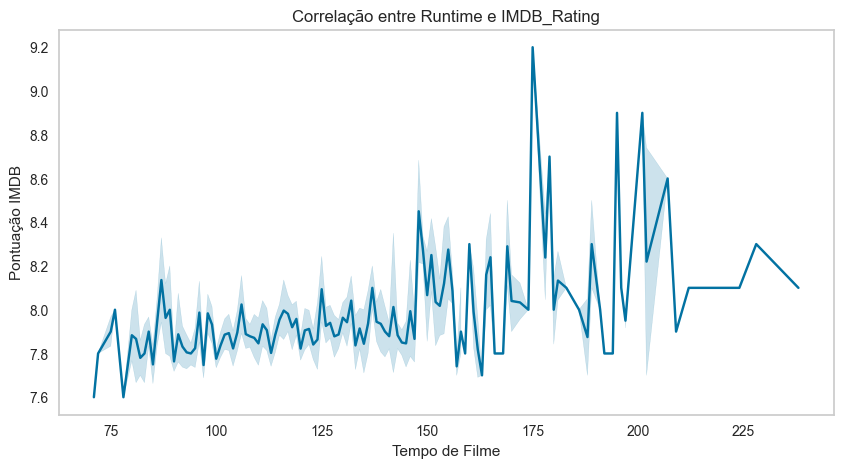

In [28]:
plt.figure(figsize=(10, 5))
sns.lineplot(df_genres, x='Runtime', y='IMDB_Rating')

plt.title('Correlação entre Runtime e IMDB_Rating')
plt.xlabel('Tempo de Filme')
plt.ylabel('Pontuação IMDB')
plt.grid()
plt.show()

## 4.5 Tendência de Faturamento ao Longo dos Anos

### Hipótese:
Há uma tendência de aumento no faturamento médio dos filmes ao longo dos anos (Released_Year), o que pode indicar o crescimento da indústria cinematográfica.

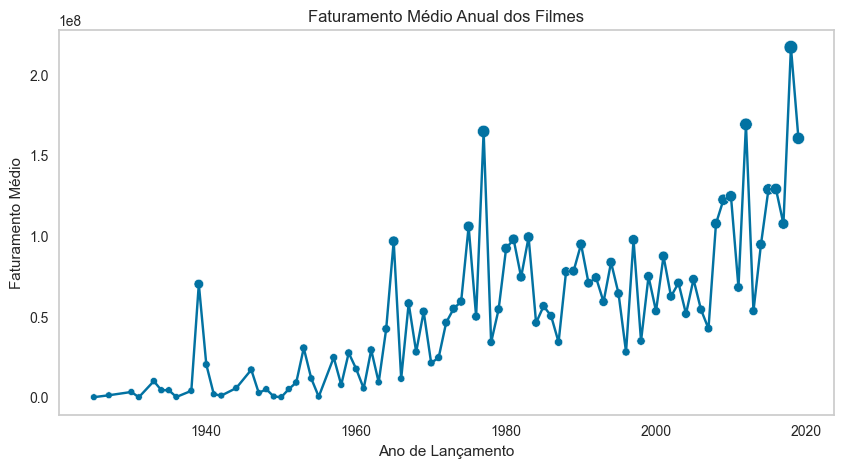

In [29]:
average_gross_by_year = df.groupby('Released_Year')['Gross'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=average_gross_by_year, x='Released_Year', y='Gross', size='Gross', legend='')
sns.lineplot(data=average_gross_by_year, x='Released_Year', y='Gross')

plt.title('Faturamento Médio Anual dos Filmes')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Faturamento Médio')
plt.grid()
plt.show()

#### Insight:
O gráfico demonstra uma clara tendência de crescimento no faturamento médio anual dos filmes ao longo do tempo. Embora existam flutuações, a curva de tendência ascendente, especialmente a partir da década de 1960, sugere um aumento significativo na receita de bilheteria ao longo dos anos.

# 5. Engenharia de Variáveis (Feature Engineering)

Para preparar os dados para a modelagem, aplicamos a padronização nas variáveis numéricas. O código abaixo utiliza o StandardScaler do scikit-learn para transformar as colunas listadas.
Esse processo garante que todas as variáveis numéricas, como Runtime e Gross_log, tenham uma média de 0 e um desvio padrão de 1. A padronização é uma etapa crucial porque evita que variáveis com escalas maiores dominem o treinamento do modelo, permitindo que o algoritmo trate todas as features com a mesma importância.

In [30]:
cols_to_standardize = [
    'IMDB_Rating',
    'Meta_score',
    'Runtime',
    'Movie_Age',
    'Star_Frequency',
    'Gross_log',
    'No_of_Votes_log'
]

scaler = StandardScaler()

df_standardized = df.copy()
df_standardized[cols_to_standardize] = scaler.fit_transform(df_standardized[cols_to_standardize])

# 6. Modelagem

In [31]:
df_modeling = df_standardized.drop(columns=['Series_Title', 'Certificate', 'Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'Released_Year'])

reg_setup = setup(
    data=df_modeling,
    target='IMDB_Rating',
    session_id=123,
    verbose=False,
    preprocess=False
)
best_model_with_overview = compare_models(sort='RMSE', n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5272,0.4669,0.6766,0.4711,0.3076,1.1785,0.1370
dummy,Dummy Regressor,0.7921,1.0294,1.0023,-0.0330,0.5979,0.9899,0.0240


In [32]:
df_modeling_without_overview = df_modeling.drop(columns=overview_df.columns)

reg_setup_without_overview = setup(
    data=df_modeling_without_overview,
    target='IMDB_Rating',
    session_id=123,
    verbose=False,
    preprocess=False
)
best_model_without_overview = compare_models(sort='RMSE', n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5305,0.4764,0.6824,0.4663,0.3103,1.1693,0.1240
dummy,Dummy Regressor,0.7921,1.0294,1.0023,-0.0330,0.5979,0.9899,0.0150


In [33]:
reg_automl= setup(
    data=df_raw.drop(columns=['Series_Title', 'Released_Year']),
    target='IMDB_Rating',
    session_id=123,
    verbose=False,
    preprocess=True
)

best_model_test = compare_models(sort='RMSE', n_select=10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.1894,0.0533,0.2301,0.2611,0.0255,0.0237,0.0580
en,Elastic Net,0.1930,0.0554,0.2347,0.2365,0.0260,0.0242,0.0540
lasso,Lasso Regression,0.1974,0.0578,0.2398,0.2040,0.0266,0.0247,0.0550
llar,Lasso Least Angle Regression,0.1974,0.0578,0.2398,0.2040,0.0266,0.0247,0.0580
ridge,Ridge Regression,0.1984,0.0597,0.2437,0.1838,0.0269,0.0248,0.0540
knn,K Neighbors Regressor,0.2072,0.0662,0.2565,0.0880,0.0285,0.0259,0.0860
et,Extra Trees Regressor,0.2174,0.0740,0.2710,-0.0007,0.0299,0.0271,0.1080
br,Bayesian Ridge,0.2188,0.0754,0.2734,-0.0168,0.0301,0.0273,0.0600
lr,Linear Regression,0.2188,0.0755,0.2735,-0.0173,0.0302,0.0273,0.0540
lar,Least Angle Regression,0.2188,0.0755,0.2735,-0.0173,0.0302,0.0273,0.0570


In [34]:
best_model_final = create_model('omp')

tuned_model = tune_model(best_model_final, optimize='RMSE', verbose=False)

save_model(tuned_model, 'modelo_imdb_final')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1775,0.0457,0.2138,0.2558,0.0237,0.0222
1,0.2081,0.0589,0.2427,0.1313,0.0270,0.0261
2,0.1955,0.0548,0.2341,0.5088,0.0257,0.0242
3,0.1801,0.0453,0.2129,0.3358,0.0237,0.0227
4,0.1728,0.0446,0.2111,0.4079,0.0235,0.0217
5,0.2047,0.0708,0.2662,0.1635,0.0294,0.0255
6,0.1924,0.0543,0.2330,-0.0809,0.0261,0.0245
7,0.1807,0.0450,0.2122,0.3384,0.0237,0.0228
8,0.2001,0.0620,0.2491,0.1873,0.0274,0.0248


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Meta_score', 'No_of_Votes'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Certificate', 'Runtime', 'Genre',
                                              'Overview', 'Director', 'Star1',
                                              'Star2', 'Star3', 'Star4',
                                              'Gross'],
                                     transformer=SimpleImputer(strategy='most_frequent'))...
                 ('rest_encoding',
                  TransformerWrapper(include=['Runtime', 'Genre', 'Overview',
                                              'Director', 'Star1', 'Star2',
                                              'Star3', 'Star4', 'Gross'],
                                     transformer=TargetEncoder(cols=['Runtime',
           

## 6.1 Análise e Escolha do Melhor Modelo

Inicialmente, com base em minha engenharia de variáveis manual, o Light Gradient Boosting Machine foi o modelo com o melhor desempenho, apresentando um RMSE de 0.6873.

No entanto, ao utilizar a abordagem de pré-processamento automático do pycaret, o desempenho do modelo foi drasticamente melhor. A ferramenta, combinada com suas próprias otimizações, resultou em um RMSE de 0.2138.

Por isso, o modelo final que será utilizado neste projeto será o gerado pelo pycaret com seu pré-processamento automático, pois ele demonstrou ser o mais preciso para prever a nota do IMDb.

# 7. Conclusão

## 7.1 Perguntas do Desafio:

### 7.1.1 Qual filme você recomendaria para uma pessoa que você não conhece?


In [35]:
top_IMDB = df.sort_values(by='IMDB_Rating', ascending=False).head(150)
top_IMDB.sort_values(by='No_of_Votes', ascending=False).head(10)[['Series_Title', 'IMDB_Rating', 'No_of_Votes', 'Genre']]

,Series_Title,IMDB_Rating,No_of_Votes,Genre
1,The Dark Knight,9.0,2303232,"Action, Crime, Drama"
7,Inception,8.8,2067042,"Action, Adventure, Sci-Fi"
8,Fight Club,8.8,1854740,Drama
5,Pulp Fiction,8.9,1826188,"Crime, Drama"
10,Forrest Gump,8.8,1809221,"Drama, Romance"
13,The Matrix,8.7,1676426,"Action, Sci-Fi"
9,The Lord of the Rings: The Fellowship of the Ring,8.8,1661481,"Action, Adventure, Drama"
4,The Lord of the Rings: The Return of the King,8.9,1642758,"Action, Adventure, Drama"
0,The Godfather,9.2,1620367,"Crime, Drama"
54,The Dark Knight Rises,8.4,1516346,"Action, Adventure"


Com base nos filmes da base e nas suas avaliações, uma recomendação que eu faria para uma pessoa que não conheço dependeria do gênero de interesse dela. Para fazer uma sugestão segura eu ofereceria opções de gêneros populares:

- Para quem gosta de ação com ficção: Recomendaria **Inception** ou **The Dark Knight**. Ambos são aclamados pela crítica.

- Para quem procura drama com crime: Sugeriria **The Godfather** ou **Pulp Fiction**. São considerados clássicos do cinema.

- Para os fãs de aventura e fantasia: A indicação seria **The Lord of the Rings: The Return of the King**. É um épico de fantasia com uma história grandiosa e efeitos visuais impressionantes.

### 7.1.2 Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

Com base na análise de correlação dos dados, os principais fatores que se relacionam com a alta expectativa de faturamento de um filme são:

- Popularidade do Filme: A popularidade, medida pelo número de votos (**No_of_Votes**), apresenta a correlação mais forte com o faturamento (**Gross**), com um valor de 0.57. Isso sugere que filmes que engajam e alcançam um grande público tendem a ter maior sucesso financeiro.

- Popularidade do Elenco: A frequência de aparição de atores de destaque no dataset (**Star_Frequency**) tem uma correlação de 0.31 com o faturamento, indicando que a presença de um elenco popular pode contribuir para a receita de bilheteria.

Aprofundando na análise de popularidade, foi observado que a presença de figuras icônicas como **Tom Hanks** e **Steven Spielberg** tem uma **correlação positiva** e, embora fraca, mensurável com o faturamento. A correlação de 0.16 para Tom Hanks e 0.14 para Steven Spielberg sugere que, para além da popularidade geral dos atores (**Star_Frequency**), a presença de nomes extremamente influentes pode gerar um impacto sutil, mas positivo, na bilheteria de um filme.

### 7.1.3 Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?


In [36]:
from pycaret.classification import setup, compare_models

df_genre_overview = df_genres[['Genre', 'Overview']].reset_index()

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df_genre_overview['Overview'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df_final_classification = pd.concat([tfidf_df, df_genre_overview['Genre'].reset_index(drop=True)], axis=1)

clf = setup(
    data=df_final_classification,
    target='Genre',
    session_id=123,
    verbose=False,
    preprocess=False,
)

compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.2781,0.2000,0.2781,0.0774,0.1210,0.0000,0.0000,0.1390
ada,Ada Boost Classifier,0.2721,0.0000,0.2721,0.0855,0.1217,-0.0015,-0.0043,0.2840
lr,Logistic Regression,0.2511,0.0000,0.2511,0.0834,0.1227,-0.0053,-0.0099,0.2580
knn,K Neighbors Classifier,0.1424,0.2193,0.1424,0.1137,0.1202,-0.0133,-0.0136,0.1590
lightgbm,Light Gradient Boosting Machine,0.0929,0.2024,0.0929,0.0751,0.0818,-0.0542,-0.0548,3.9640
et,Extra Trees Classifier,0.0922,0.1726,0.0922,0.0777,0.0815,-0.0518,-0.0523,1.1260
rf,Random Forest Classifier,0.0892,0.2099,0.0892,0.0614,0.0721,-0.0721,-0.0735,0.8310
ridge,Ridge Classifier,0.0839,0.0000,0.0839,0.0675,0.0720,-0.0686,-0.0694,0.1700
nb,Naive Bayes,0.0734,0.1917,0.0734,0.0823,0.0764,-0.0347,-0.0349,0.1680
gbc,Gradient Boosting Classifier,0.0697,0.0000,0.0697,0.0555,0.0608,-0.0722,-0.0728,10.0110


[DummyClassifier(constant=None, random_state=123, strategy='prior'),
 AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=123),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)]

Para verificar a possibilidade de inferir o gênero a partir da sinopse, foi realizada uma modelagem de classificação. O texto do Overview foi transformado em dados numéricos usando TfidfVectorizer e, em seguida, um modelo foi treinado para prever o gênero.

O resultado do modelo (Dummy Classifier como melhor) sugere que não foi possível inferir o gênero de forma eficaz a partir da sinopse. Isso indica que o texto, com as técnicas utilizadas, não continha informações suficientes para diferenciar os gêneros.

### 7.1.4 Supondo um filme com as seguintes características ... qual seria a nota do IMDB?


In [38]:
movie_raw = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}

df_movie_raw = pd.DataFrame([movie_raw])

print(f"Nota prevista do IMDb: {float(predict_model(tuned_model, df_movie_raw)['prediction_label']):.2f}")

Nota prevista do IMDb: 8.85
